In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from os.path import split, splitext
%matplotlib inline

In [2]:
images = ('grayball.jpg', 'berndsface.jpg')
targetGrayMean = [0.26, 0.2]

In [3]:
def adjust_gamma(image, gamma=1.0):
    
    invGamma = gamma
    table = (np.array([((i / 255) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8"))
    
    return cv2.LUT(image, table)

In [4]:
def color_balancing(img, method, upper_limit, target_gray_mean):
    rgb = img[:,:,::-1] / 255.
    rows, cols, channels = rgb.shape
    if method == 'gray-world':
        mean_rgb = rgb.mean(2).mean(1)
        k = mean_rgb[1] / mean_rgb
    elif method == 'scale-by-max':
        max_rgb = rgb.max(1).max(0)
        k = upper_limit/max_rgb
    elif method == 'shades-of-gray':
        p = 6
        mpnorm = np.zeros((3, 1))
        for i in range(3):
            pix = rgb[:,:,i]
            mpnorm[i] = (pix**p).sum()**(1/p)
        k = mpnorm[2]/mpnorm
    elif method == 'gray-edge':
        p = 1
        mpnorm = np.zeros((3, 1))
        rgb_grad = gradient_magnitude(rgb);
        for i in range(3):
            pix_grad = rgb_grad[:,:,i]
            mpnorm[i] = (pix_grad**p).sum()**(1/p)
        k = mpnorm[2]/mpnorm
    elif method == 'max-edge':
        mpnorm = np.zeros((3, 1))
        rgb_grad = gradient_magnitude(rgb)
        for i in range(3):
            pix_grad = rgb_grad[:,:,i]
            mpnorm[i] = pix_grad.max()
        k = mpnorm[2]/mpnorm
    else:
        print('method %d is not supported.'%method)
        return [], []
    # Apply scaling factor
    rgb_balanced = np.zeros_like(rgb);
    for c in range(3):
        temp = rgb[:,:,c]*k[c]
        temp[temp>upper_limit[c]] = upper_limit[c]
        rgb_balanced[:,:,c] = temp
    # Find brightness scale factor
    imgGray = cv2.cvtColor((rgb_balanced.copy() * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    # plt.imshow(imgGray, 'gray')
    # plt.show()
    imgGray = imgGray / 255.
    imgGrayMean = imgGray.mean()
    grayK = target_gray_mean / imgGrayMean
    # % Apply brightness scale factor
    for c in range(3):
        temp = rgb_balanced[:,:,c]*grayK
        temp[temp>upper_limit[c]] = upper_limit[c]
        rgb_balanced[:,:,c] = temp
    return rgb_balanced, k

In [5]:
def gradient_magnitude(img):
    rows, cols, channels = img.shape
    imgGrad = np.zeros_like(img)
    sigma = 1;
    for i in range(3):
        # pix = reshape(img(:,:,i), rows, cols);
        pix = img[:,:,i].copy()
        pix = cv2.GaussianBlur(pix, (5*sigma, 5*sigma), sigma)
        pix_dx = cv2.Sobel(pix,cv2.CV_64F,1,0)
        pix_dy = cv2.Sobel(pix,cv2.CV_64F,0,1)
        imgGrad[:,:,i] = (pix_dx**2 + pix_dy**2)**0.5
    return imgGrad

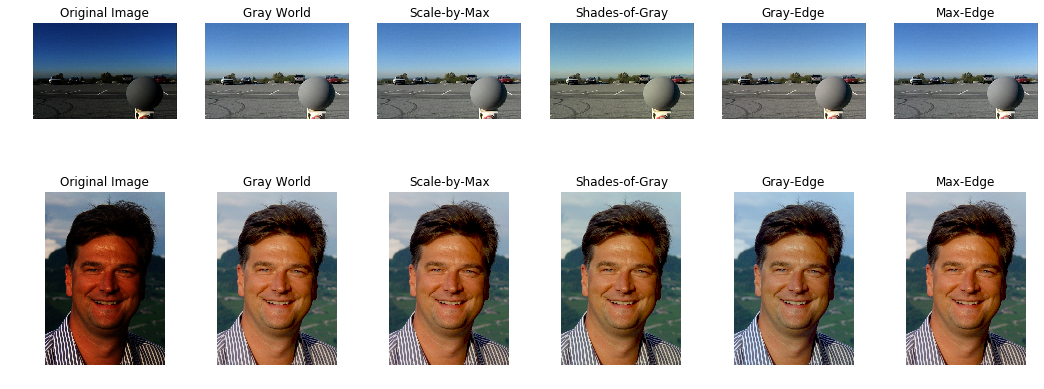

In [6]:
l_images = len(images)
fig, ax = plt.subplots(l_images, 6,figsize=(18,7))
for nImage, image in enumerate(images):
    img = cv2.imread(image)
    name, ext = splitext(image)
    path, name = split(name)
    gamma = 2.2
    img = adjust_gamma(img, gamma)
    ax[nImage, 0].imshow(img[:,:,::-1]);
    ax[nImage, 0].axis('off')
    ax[nImage, 0].set_title('Original Image')
    # Perform gray world
    imgCB, _ = color_balancing(img, 'gray-world', [1, 1, 1], targetGrayMean[nImage]);
    imgCB = adjust_gamma((imgCB*255).astype(np.uint8), 1/gamma);
    ax[nImage, 1].imshow(imgCB)
    ax[nImage, 1].axis('off')
    ax[nImage, 1].set_title('Gray World')
    # Perform scale-by-max
    imgCB, _ = color_balancing(img, 'scale-by-max', [1, 1, 1], targetGrayMean[nImage]);
    imgCB = adjust_gamma((imgCB*255).astype(np.uint8), 1/gamma);
    ax[nImage, 2].imshow(imgCB)
    ax[nImage, 2].axis('off')
    ax[nImage, 2].set_title('Scale-by-Max')
    # Perform shades-of-gray
    imgCB, _ = color_balancing(img, 'shades-of-gray', [1, 1, 1], targetGrayMean[nImage]);
    imgCB = adjust_gamma((imgCB*255).astype(np.uint8), 1/gamma);
    ax[nImage, 3].imshow(imgCB)
    ax[nImage, 3].axis('off')
    ax[nImage, 3].set_title('Shades-of-Gray')
    # Perform gray-edge
    imgCB, _ = color_balancing(img, 'gray-edge', [1, 1, 1], targetGrayMean[nImage]);
    imgCB = adjust_gamma((imgCB*255).astype(np.uint8), 1/gamma);
    ax[nImage, 4].imshow(imgCB)
    ax[nImage, 4].axis('off')
    ax[nImage, 4].set_title('Gray-Edge')
    # Perform max-edge
    imgCB, _ = color_balancing(img, 'max-edge', [1, 1, 1], targetGrayMean[nImage]);
    imgCB = adjust_gamma((imgCB*255).astype(np.uint8), 1/gamma);
    ax[nImage, 5].imshow(imgCB)
    ax[nImage, 5].axis('off')
    ax[nImage, 5].set_title('Max-Edge')
